# Analysis of Local and Central DP-GMM

In this notebook we will compare our DP-GMM implementations.

## Imports

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import sys
import os

# add src to path for easier local imports
sys.path.append(os.path.join(os.getcwd(), "src"))
from base_gmm import GMM
from ldp_gmm import LDPGMM

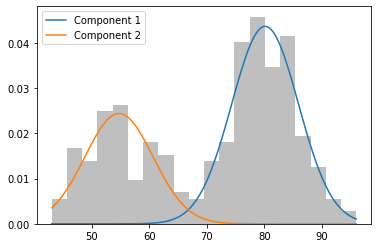

In [4]:
# read in data
df = pd.read_csv("data/old_faithful.csv")
wait_dat = df["waiting"].values.astype(int)

# create non-DP GMM object and fit to data
nondp_gmm = GMM(n_components=2)
nondp_gmm.fit(wait_dat.reshape(-1, 1))
nondp_gmm.plot_mixture(bins=20)

In [5]:
# get non-DP GMM components
nondp_means = nondp_gmm.means_.flatten()
nondp_covs = nondp_gmm.covariances_.flatten()
nondp_weights = nondp_gmm.weights_.flatten()
nondp_comp1 = (nondp_means[0], nondp_covs[0], nondp_weights[0])
nondp_comp2 = (nondp_means[1], nondp_covs[1], nondp_weights[1])
print(f"True means: {nondp_means[0], nondp_means[1]}")
print(f"True covariances: {nondp_covs[0], nondp_covs[1]}")
print(f"True weights: {nondp_weights[0], nondp_weights[1]}")

True means: (80.14546556133251, 54.699842709202834)
True covariances: (33.790215792564595, 35.31764935665252)
True weights: (0.6365423321901911, 0.3634576678098091)


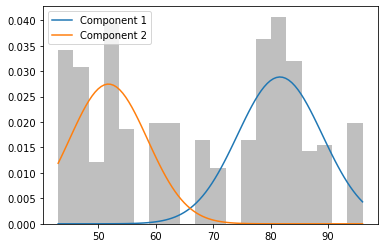

In [6]:
# create local-DP GMM object and fit to data
ldp_gmm = LDPGMM(n_components=2, epsilon=1)
ldp_gmm.fit_ldp(wait_dat.reshape(-1, 1))
ldp_gmm.plot_mixture(bins=20)

In [7]:
# get locaL-DP GMM components
ldp_means = ldp_gmm.means_.flatten()
ldp_covs = ldp_gmm.covariances_.flatten()
ldp_weights = ldp_gmm.weights_.flatten()
ldp_comp1 = (ldp_means[0], ldp_covs[0], ldp_weights[0])
ldp_comp2 = (ldp_means[1], ldp_covs[1], ldp_weights[1])
print(f"LDP means: {ldp_means[0], ldp_means[1]}")
print(f"LDP covariances: {ldp_covs[0], ldp_covs[1]}")
print(f"LDP weights: {ldp_weights[0], ldp_weights[1]}")

LDP means: (81.61743189655549, 51.76117308094935)
LDP covariances: (54.41709281267687, 45.88189014165064)
LDP weights: (0.5336470509742153, 0.4663529490257837)


Compare non-DP and local-DP mixtures.

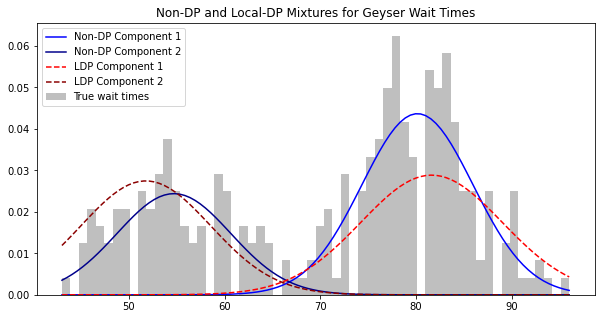

In [8]:
# Creating plot
x = np.linspace(wait_dat.min(), wait_dat.max(), 100)
plt.figure(figsize=(10, 5))
plt.hist(wait_dat, bins=60, density=True, color="gray", alpha=0.5, label="True wait times")
plt.plot(x, nondp_comp1[2]*sp.stats.norm(nondp_comp1[0], nondp_comp1[1]**0.5).pdf(x), color="blue", label="Non-DP Component 1")
plt.plot(x, nondp_comp2[2]*sp.stats.norm(nondp_comp2[0], nondp_comp2[1]**0.5).pdf(x), color="darkblue", label="Non-DP Component 2")
plt.plot(x, ldp_comp1[2]*sp.stats.norm(ldp_comp1[0], ldp_comp1[1]**0.5).pdf(x), color="red", label="LDP Component 1", linestyle="--")
plt.plot(x, ldp_comp2[2]*sp.stats.norm(ldp_comp2[0], ldp_comp2[1]**0.5).pdf(x), color="darkred", label="LDP Component 2", linestyle="--")
plt.title("Non-DP and Local-DP Mixtures for Geyser Wait Times")
plt.legend()
plt.show()

In [9]:
# Defining function to get distribution parameters for DP and non-DP GMMs
def get_params(data, n_components, epsilon = 0, DP = False):

    #Create a local GMM object
    model = LDPGMM(n_components = n_components, epsilon = epsilon)
    
    #Fit on the data
    if DP:
        model.fit_ldp(data.reshape(-1,1))
    else:
        model.fit(data.reshape(-1,1))   
    #Create matrix of 0's to fill with model parameters
    dists = np.zeros((n_components, 3))
        
    # Store the value of each component in the distribution matrices
    for i in range(n_components):
        dists[i,:] = [model.means_[i][0],model.covariances_[i][0][0], model.weights_[i]]
    
    return dists

In [15]:
# Define simulation parameters
samples = 20 # Number of sample sizes to test
components = 3 # Number of distributions per sample
epsilon = 7 # Privacy Parameter
iters = 10 # Times to test each sample size
min_size = 500
max_size = 10000

# Create array of sample sizes
ns = np.linspace(min_size,max_size, samples).astype(int)

#Create matrix for each distribution with number of samples and components
dp_dist1 = np.zeros((samples,components))
dp_dist2 = np.zeros((samples,components))
dp_dist3 = np.zeros((samples,components))

true_dist1 = np.zeros((samples,components))
true_dist2 = np.zeros((samples,components))
true_dist3 = np.zeros((samples,components))

#Make a list of the matrices for looping through when storing values
dp_dists_list = [dp_dist1, dp_dist2, dp_dist3]
true_dists_list = [true_dist1, true_dist2, true_dist3]

#Simulation
for i,n in enumerate(ns):
    
    #Create random data with distributions
    pis = [0.2, 0.4, 0.4]  # Proportions of distributions
    mus = [17, 30, 50] # Means of distributions
    sigmas = [5**2, 4**2, 5**2] #Covariances of distributions
    K = len(pis) # Number of distributions
    
    # Make hist integers because that's what the local model handles
    zs = np.random.choice(np.arange(K), size=n, p=pis)
    y = np.array([np.random.normal(mus[z], sigmas[z]**0.5, 1)[0] for z in zs]).astype(int)
    
    # Using GMM class to get distribution parameters
    true_dists = get_params(y, components, epsilon)
    
    #Sorting parameters so they can be compared
    sort_indices = np.argsort(true_dists[:,0])
    true_dists = true_dists[sort_indices,:]
    
    # Creating a matrix for each distribution to store for the different iterations
    dist1_trial = np.zeros((iters,components))
    dist2_trial = np.zeros((iters,components))
    dist3_trial = np.zeros((iters,components))
    
    # Looping through and conducting the local model on iters amount of distributions
    for k in range(iters):
        
        # Using GMM class to get DP distribution parameters
        dp_dists = get_params(y, components, epsilon, DP = True)
        
        #Sorting parameters so they can be compared
        sort_indices = np.argsort(dp_dists[:,0])
        dp_dists = dp_dists[sort_indices,:]
        
        #Stroing values
        dist1_trial[k,:] = dp_dists[0,:]
        dist2_trial[k,:] = dp_dists[1,:]
        dist3_trial[k,:] = dp_dists[2,:]
    
    #Creating a list of trial distributions
    trial_dists = [dist1_trial, dist2_trial, dist3_trial]
    
    #Storing the values
    for j in range(components):
        true_dists_list[j][i,:] = true_dists[j,:]
        dp_dists_list[j][i,:] = np.mean(trial_dists[j], axis = 0)
    
    #Tracking completion
    print('iteration ' + str(i) + ' finished')
    

#Getting bias for each parameter in each distribution
mu1_bias = abs(dp_dist1[:,0] - true_dist1[:,0])
mu2_bias = abs(dp_dist2[:,0] - true_dist2[:,0])
mu3_bias = abs(dp_dist3[:,0] - true_dist3[:,0])

pi1_bias = abs(dp_dist1[:,2] - true_dist1[:,2])
pi2_bias = abs(dp_dist2[:,2] - true_dist2[:,2])
pi3_bias = abs(dp_dist3[:,2] - true_dist3[:,2])

sigma1_bias = abs(dp_dist1[:,1] - true_dist1[:,1])
sigma2_bias = abs(dp_dist2[:,1] - true_dist2[:,1])
sigma3_bias = abs(dp_dist3[:,1] - true_dist3[:,1])

iteration 0 finished
iteration 1 finished
iteration 2 finished
iteration 3 finished
iteration 4 finished
iteration 5 finished
iteration 6 finished
iteration 7 finished
iteration 8 finished
iteration 9 finished
iteration 10 finished
iteration 11 finished
iteration 12 finished
iteration 13 finished
iteration 14 finished
iteration 15 finished
iteration 16 finished
iteration 17 finished
iteration 18 finished
iteration 19 finished


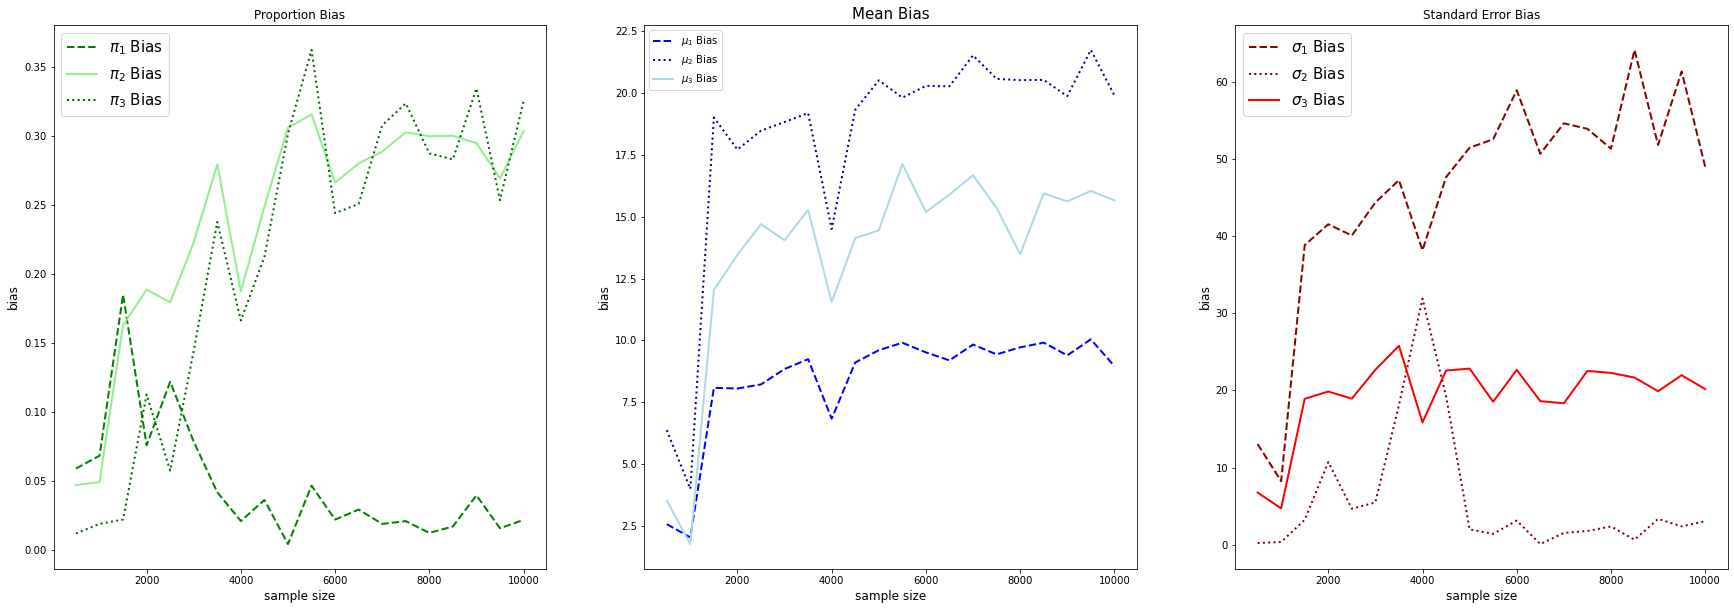

In [23]:
#Plotting the results
fig, ax = plt.subplots(1,3,figsize = (30,10))

ax[1].plot(ns, mu1_bias, label = '$\mu_1$ Bias', color = 'blue', linewidth = 2, linestyle = '--')
ax[1].plot(ns, mu2_bias, label = '$\mu_2$ Bias', color = 'darkblue', linewidth = 2, linestyle = 'dotted')
ax[1].plot(ns, mu3_bias, label = '$\mu_3$ Bias', color = 'lightblue', linewidth = 2)
ax[1].set_ylabel('bias', fontsize = 12)
ax[1].set_xlabel('sample size', fontsize = 12)
ax[1].set_title('Mean Bias', fontsize = 15)
ax[1].legend(loc = 'best')

ax[0].plot(ns, pi1_bias, label = '$\pi_1$ Bias', color = 'green', linewidth = 2, linestyle = '--')
ax[0].plot(ns, pi2_bias, label = '$\pi_2$ Bias', color = 'lightgreen', linewidth = 2)
ax[0].plot(ns, pi3_bias, label = '$\pi_3$ Bias', color = 'darkgreen', linewidth = 2, linestyle = 'dotted')
ax[0].set_ylabel('bias', fontsize = 12)
ax[0].set_xlabel('sample size', fontsize = 12)
ax[0].set_title('Proportion Bias')
ax[0].legend(loc = 'best', fontsize = 15)

ax[2].plot(ns, sigma1_bias, label = '$\sigma_1$ Bias', color = 'darkred', linewidth = 2, linestyle = '--')
ax[2].plot(ns, sigma2_bias, label = '$\sigma_2$ Bias', color = 'maroon', linewidth = 2, linestyle = 'dotted')
ax[2].plot(ns, sigma3_bias, label = '$\sigma_3$ Bias', color = 'red', linewidth = 2)
ax[2].set_ylabel('bias', fontsize = 12)
ax[2].set_xlabel('sample size', fontsize = 12)
ax[2].set_title('Standard Error Bias')
ax[2].legend(loc = 'best', fontsize = 15)

plt.show()